In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
def fn(X):
    return np.stack([
        X[:, 0] + X[:, 1],
        X[:, 1] ** 2,
    ], axis=1)

rng = np.random.default_rng(123)
X = rng.uniform(0, 1, (100, 3))
y = fn(X)

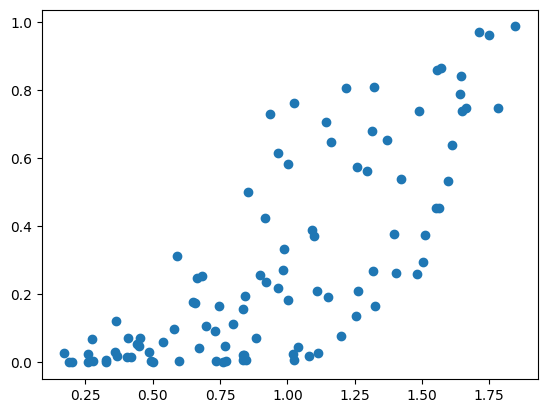

In [4]:
plt.scatter(y[:, 0], y[:, 1])

In [6]:
class KernelRegression(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        # self.w_q = torch.nn.Linear(input_dim, hidden_dim)
        # self.w_k = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        
        self.w_q = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.InstanceNorm1d(hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.w_k = self.w_q
        self.w_v = torch.nn.Identity()

    def forward(self, queries, keys, values):
        # queries: (n_queries, hidden_dim)
        # keys: (n_keys, hidden_dim)
        # values: (n_keys, hidden_dim)
        queries = self.w_q(queries)
        keys = self.w_k(keys)
        values = self.w_v(values)
        
        logits = queries @ keys.T
        weights = torch.softmax(logits, dim=1)
        # weights: (n_queries, n_keys)
        return weights @ values  # (n_queries, hidden_dim)


In [7]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

model = KernelRegression(input_dim=3, hidden_dim=8)
optim = torch.optim.AdamW(model.parameters(), lr=1.e-3)

history = []
for i in tqdm(range(10000)):
    loss = (
        (model(X_tensor, X_tensor, y_tensor) - y_tensor).pow(2)
        .sum(-1).mean()
    )
    optim.zero_grad()
    loss.backward()
    optim.step()
    history.append(loss.item())

with torch.inference_mode():
    train_preds = model(X_tensor, X_tensor, y_tensor)
    

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\bobin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


X_train,X_test,Y_train,Y_test = train_test_split(X_tensor, y_tensor, test_size=0.1)

model = KernelRegression(input_dim=3, hidden_dim=8)
optim = torch.optim.AdamW(model.parameters(), lr=1.e-3)

history = []

for _ in tqdm(range(10000)):
    loss = (model(X_train, X_train, Y_train) - Y_train).pow(2).sum(-1).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    history.append(loss.item())



  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\bobin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


In [25]:
with torch.inference_mode():
    train_preds = model(X_train, X_train, Y_train)
    test_preds = model(X_test, X_train, Y_train)
    mse, mae, r2 = mean_squared_error(Y_test.numpy(), test_preds.numpy()), mean_absolute_error(Y_test.numpy(), test_preds.numpy()), r2_score(Y_test.numpy(), test_preds.numpy())

In [26]:
print(mse, mae, r2)

0.00040522776544094086 0.017092781141400337 0.9955043792724609


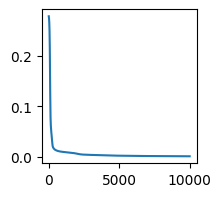

In [17]:
plt.figure(figsize=(2, 2))
plt.plot(history)

In [27]:
history[-1]

0.0008974849479272962

In [29]:
train_preds.shape

torch.Size([90, 2])

In [30]:
tp = train_preds.numpy()

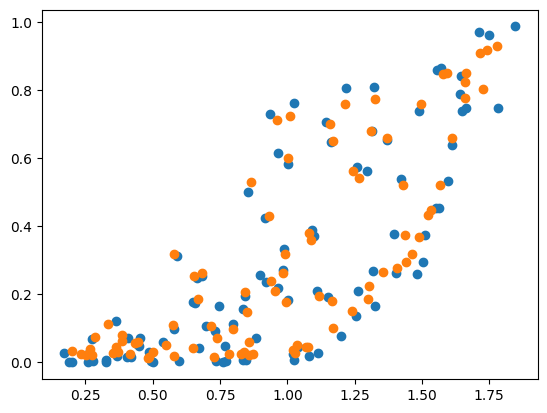

In [31]:
plt.scatter(y[:, 0], y[:, 1])
plt.scatter(tp[:, 0], tp[:, 1])

## Задание:

0. Добавить тестирование и подсчёт метрик (MSE, MAE, R2) на отложенной выборке.
1. Переделать реализацию на Multi-Head Attention.
2. Реализовать Grouped Query Attention.

*(В рамках данной задачи с ядерной регрессией)*

In [55]:
class MultiHeadKernelRegression(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_heads:int, out_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = self.hidden_dim // self.num_heads
        
        self.w_q = torch.nn.ModuleList(
                    [
                    torch.nn.Sequential(
                    torch.nn.Linear(input_dim, self.head_dim),
                    torch.nn.InstanceNorm1d(self.head_dim),
                    torch.nn.SiLU(),
                    torch.nn.Linear(self.head_dim, self.head_dim)) for i in range(self.num_heads)] 
        )
        
        self.w_k = self.w_q
        self.w_v = torch.nn.ModuleList([torch.nn.Linear(out_dim, self.head_dim) for _ in range(self.num_heads)])
        self.w_o = torch.nn.Linear(self.hidden_dim, out_dim)
        
    def forward(self, queries, keys, values):
        # queries: (n_queries, hidden_dim)
        # keys: (n_keys, hidden_dim)
        # values: (n_keys, hidden_dim)
        head_results = []
        for i in range(len(self.w_q)):
            q_i = self.w_q[i](queries)
            k_i = self.w_k[i](keys)
            v_i = self.w_v[i](values)
            logits = (q_i @ k_i.T) / (self.head_dim ** 0.5)
            weights = torch.softmax(logits, dim=1)
            head_results.append(weights @ v_i)
        
        return self.w_o(torch.cat(head_results, dim=1))

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


X_train,X_test,Y_train,Y_test = train_test_split(X_tensor, y_tensor, test_size=0.1)

model = MultiHeadKernelRegression(input_dim=3, hidden_dim=8, num_heads=2, out_dim=2)
optim = torch.optim.AdamW(model.parameters(), lr=1.e-3)

history = []

for _ in tqdm(range(10000)):
    loss = (model(X_train, X_train, Y_train) - Y_train).pow(2).sum(-1).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    history.append(loss.item())



  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\bobin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


In [57]:
with torch.inference_mode():
    train_preds = model(X_train, X_train, Y_train)
    test_preds = model(X_test, X_train, Y_train)
    mse, mae, r2 = mean_squared_error(Y_test.numpy(), test_preds.numpy()), mean_absolute_error(Y_test.numpy(), test_preds.numpy()), r2_score(Y_test.numpy(), test_preds.numpy())

In [58]:
print(mse, mae, r2)

4.552707105176523e-05 0.00620043883100152 0.9996922016143799


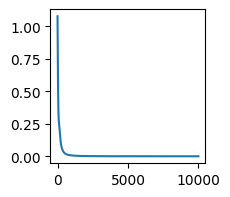

In [59]:
plt.figure(figsize=(2, 2))
plt.plot(history)

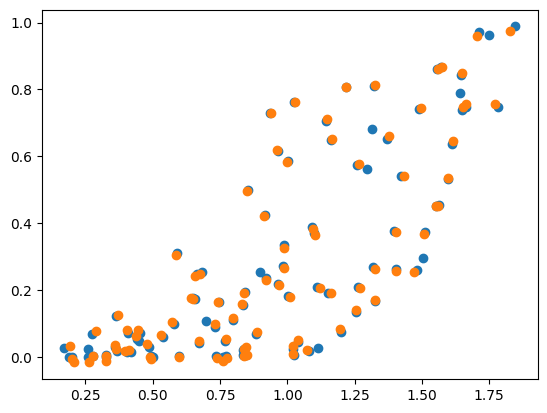

In [60]:
plt.scatter(y[:, 0], y[:, 1])
plt.scatter(train_preds.numpy()[:, 0], train_preds.numpy()[:, 1])

## LLM-а сказала, что я нуб и нормальные люди так не пишут вообще, правда ли что torch.nn.ModuleList вообще никто не использует и проще все уже разделить в forward'e? И LLM сказала, что такой вариант вообще не оптимальный и жрет много ресурсов я не могу понять почему, если честно.

In [69]:
class GroupedQueryAttentionKernelRegression(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_q_heads:int, num_kv_heads: int, out_dim: int):
        super().__init__()
        self.head_dim = hidden_dim // num_q_heads
        self.hidden_dim = hidden_dim
        self.num_q_heads = num_q_heads
        self.num_kv_heads = num_kv_heads
        self.group_size = self.num_q_heads // self.num_kv_heads
        self.w_q = torch.nn.ModuleList([
                                        torch.nn.Sequential(
                                        torch.nn.Linear(input_dim, self.head_dim),
                                        torch.nn.InstanceNorm1d(self.head_dim),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(self.head_dim, self.head_dim)) for i in range(self.num_q_heads)
        ])

        self.w_v = torch.nn.ModuleList([torch.nn.Linear(out_dim, self.head_dim) for _ in range(self.num_kv_heads)])
        self.w_k = torch.nn.ModuleList([torch.nn.Linear(input_dim, self.head_dim) for _ in range(self.num_kv_heads)])
        self.w_o = torch.nn.Linear(self.hidden_dim, out_dim)

    def forward(self, queries, keys, values):
        
        head_results = []
        kv_idx = 0
        for i in range(0, self.num_q_heads):
            q_i = self.w_q[i](queries)
            kv_idx = i // self.group_size
            k_i = self.w_k[kv_idx](keys)
            v_i = self.w_v[kv_idx](values)
            logits = (q_i @ k_i.T) / (self.head_dim ** 0.5)
            weights = torch.softmax(logits, dim=1)
            head_results.append(weights @ v_i)
        
        return self.w_o(torch.cat(head_results, dim=1))

In [70]:
X_train,X_test,Y_train,Y_test = train_test_split(X_tensor, y_tensor, test_size=0.1)

model = GroupedQueryAttentionKernelRegression(input_dim=3, hidden_dim=8, num_q_heads=2, num_kv_heads=2, out_dim=2)
optim = torch.optim.AdamW(model.parameters(), lr=1.e-3)

history = []

for _ in tqdm(range(10000)):
    loss = (model(X_train, X_train, Y_train) - Y_train).pow(2).sum(-1).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    history.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\bobin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


In [71]:
with torch.inference_mode():
    train_preds = model(X_train, X_train, Y_train)
    test_preds = model(X_test, X_train, Y_train)
    mse, mae, r2 = mean_squared_error(Y_test.numpy(), test_preds.numpy()), mean_absolute_error(Y_test.numpy(), test_preds.numpy()), r2_score(Y_test.numpy(), test_preds.numpy())

In [72]:
print(mse, mae, r2)

2.371923255850561e-05 0.0038471221923828125 0.9997604489326477


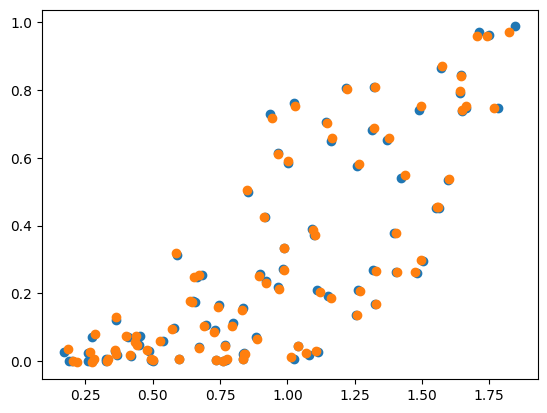

In [75]:
plt.scatter(Y_train[:, 0], Y_train[:, 1])
plt.scatter(train_preds.numpy()[:, 0], train_preds.numpy()[:, 1])

## Насколько я понимаю так мы быстрее считаем матрицы большие потому что GPU проще работает с большим массивом чем с множеством маленьких?

In [143]:
class OptimizedMultiHeadKernelRegression(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_heads:int, out_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = self.hidden_dim // self.num_heads
        
        self.w_q =  torch.nn.Sequential(torch.nn.Linear(input_dim, self.head_dim),
                                        torch.nn.InstanceNorm1d(self.head_dim),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(self.head_dim, self.hidden_dim))
        
        self.w_k = self.w_q
        self.w_v = torch.nn.Linear(out_dim, self.hidden_dim)
        self.w_o = torch.nn.Linear(self.hidden_dim, out_dim)
        
    def forward(self, queries, keys, values):
        # queries: (n_queries, hidden_dim)
        # keys: (n_keys, hidden_dim)
        # values: (n_keys, hidden_dim)
    
        queries = self.w_q(queries).view(-1, self.num_heads, self.head_dim).transpose(0, 1)
        keys = self.w_k(keys).view(-1, self.num_heads, self.head_dim).transpose(0, 1)
        values = self.w_v(values).view(-1, self.num_heads, self.head_dim).transpose(0, 1)
        logits = queries @ keys.transpose(2, 1) / (self.head_dim ** 0.5)
        weights = torch.softmax(logits, dim=-1)
        return self.w_o((weights @ values).transpose(0, 1).flatten(1))
        

In [144]:
X_train,X_test,Y_train,Y_test = train_test_split(X_tensor, y_tensor, test_size=0.1)

model = OptimizedMultiHeadKernelRegression(input_dim=3, hidden_dim=8, num_heads=2, out_dim=2)
optim = torch.optim.AdamW(model.parameters(), lr=1.e-3)

history = []

for _ in tqdm(range(10000)):
    loss = (model(X_train, X_train, Y_train) - Y_train).pow(2).sum(-1).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    history.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [145]:
with torch.inference_mode():
    train_preds = model(X_train, X_train, Y_train)
    test_preds = model(X_test, X_train, Y_train)
    mse, mae, r2 = mean_squared_error(Y_test.numpy(), test_preds.numpy()), mean_absolute_error(Y_test.numpy(), test_preds.numpy()), r2_score(Y_test.numpy(), test_preds.numpy())

In [146]:
print(mse, mae, r2)

6.526791548822075e-05 0.006840500049293041 0.9974722862243652


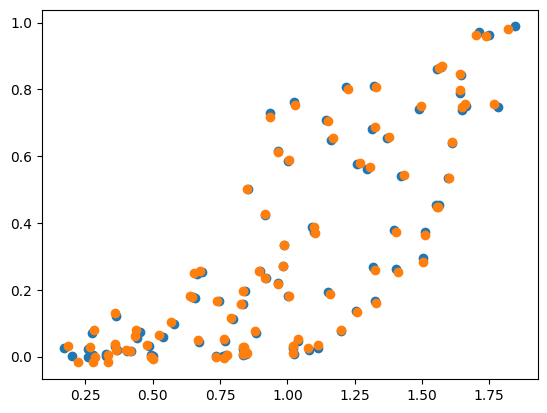

In [147]:
plt.scatter(Y_train[:, 0], Y_train[:, 1])
plt.scatter(train_preds.numpy()[:, 0], train_preds.numpy()[:, 1])

In [157]:
class OptimizedQueryAttentionKernelRegression(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_q_heads:int, num_kv_heads: int, out_dim: int):
        super().__init__()
        self.head_dim = hidden_dim // num_q_heads
        
        self.hidden_dim = hidden_dim
        self.num_q_heads = num_q_heads
        self.num_kv_heads = num_kv_heads
        
        self.group_size = self.num_q_heads // self.num_kv_heads
        
        self.w_q =  torch.nn.Sequential(torch.nn.Linear(input_dim, self.head_dim),
                                        torch.nn.InstanceNorm1d(self.head_dim),
                                        torch.nn.SiLU(),
                                        torch.nn.Linear(self.head_dim, self.hidden_dim))
        

        self.w_v = torch.nn.Linear(out_dim, self.num_kv_heads * self.head_dim)
        self.w_k = torch.nn.Linear(input_dim, self.num_kv_heads * self.head_dim)
        
        self.w_o = torch.nn.Linear(self.hidden_dim, out_dim)

    def forward(self, queries, keys, values):
        queries = self.w_q(queries).view(-1, self.num_q_heads, self.head_dim).transpose(0, 1)
        keys = self.w_k(keys).view(-1, self.num_kv_heads, self.head_dim).transpose(0, 1)
        values = self.w_v(values).view(-1, self.num_kv_heads, self.head_dim).transpose(0, 1)
        keys = keys.repeat_interleave(self.group_size, dim=0)
        values = values.repeat_interleave(self.group_size, dim=0)

        logits = queries @ keys.transpose(2, 1)
        weights = torch.softmax(logits, dim=-1)
        return self.w_o((weights @ values).transpose(0, 1).flatten(1))

In [158]:
X_train,X_test,Y_train,Y_test = train_test_split(X_tensor, y_tensor, test_size=0.1)

model = OptimizedQueryAttentionKernelRegression(input_dim=3, hidden_dim=8, num_q_heads=2, num_kv_heads=2, out_dim=2)
optim = torch.optim.AdamW(model.parameters(), lr=1.e-3)

history = []

for _ in tqdm(range(10000)):
    loss = (model(X_train, X_train, Y_train) - Y_train).pow(2).sum(-1).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    history.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\bobin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


In [159]:
with torch.inference_mode():
    train_preds = model(X_train, X_train, Y_train)
    test_preds = model(X_test, X_train, Y_train)
    mse, mae, r2 = mean_squared_error(Y_test.numpy(), test_preds.numpy()), mean_absolute_error(Y_test.numpy(), test_preds.numpy()), r2_score(Y_test.numpy(), test_preds.numpy())

In [160]:
print(mse, mae, r2)

4.318122228141874e-05 0.005744697991758585 0.9997026920318604


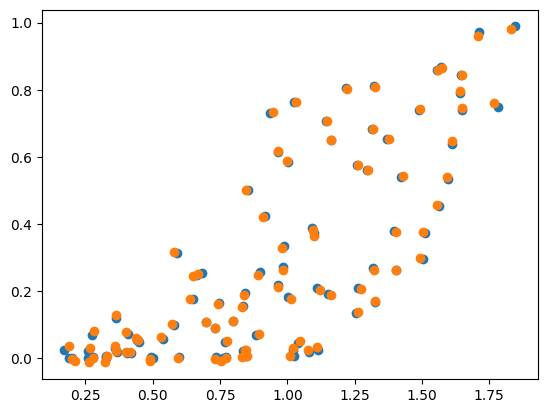

In [161]:
plt.scatter(Y_train[:, 0], Y_train[:, 1])
plt.scatter(train_preds.numpy()[:, 0], train_preds.numpy()[:, 1])